In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import seaborn as sns
from operator import add
from datetime import datetime
from tqdm import tqdm
import random

### Loading data

In [2]:
spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/10 02:00:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data_df = spark.read.csv('MDA2022ProjectData.csv', header=True).sample(fraction=0.005)
data_df = data_df.filter(data_df['ORIGINE_CAR_KEY'] == data_df['FINAL_CAR_KEY'])
data_df.show(10)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010053|      284|       64298503|     64298503|               6|       161|2021-12-22 00:53:59|
|   22010039|      284|       65237311|     65237311|               6|       161|2021-12-22 01:37:17|
|   22010053|      284|       65056837|     65056837|               6|       161|2021-12-22 01:18:50|
|   22010054|      284|       37071281|     37071281|               6|       161|2021-12-22 00:29:51|
|   22010047|      284|       66246576|     66246576|               6|       161|2021-12-22 01:38:26|
|   22010053|      284|       41009942|     41009942|               6|       161|2021-12-22 01:12:44|
|   22010078|      284|       32641909|     32641909|               6|       161|2

### Formatting data into desired format

In [4]:
# convert data to rdd format
raw_data_rdd = data_df.rdd.map(lambda x: (x['DEVICE_CODE'], x['PASS_DAY_TIME']))

In [5]:
# find day and hour
def to_day_hour(row):
    camera_code, date_time = row
    date_time = datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S')
    return (camera_code, (date_time.weekday(), date_time.hour))
    

In [6]:
data_rdd = raw_data_rdd.map(to_day_hour)
camera_list = data_rdd.map(lambda x: x[0]).distinct().collect()
camera2index = {camera: index for index, camera in enumerate(camera_list)}
index2camera = {index: camera for index, camera in enumerate(camera_list)}

In [7]:
def count(row):
    return (row, 1)

data_values = data_rdd.map(count)

In [8]:
M = np.zeros((len(camera_list), 24*7))

In [9]:
records = data_values.reduceByKey(add).collect()

for record in records:
    key, value = record
    camera = key[0]
    day, hour = key[1]
    M[camera2index[camera], 24*day + hour] = value

mean = M - np.mean(M, axis=1).reshape((-1, 1)) 
M = M - mean

### Learning the collaborative filter

In [10]:
MIN_CAMERA_DETECTS = 60
DELETE_DETECT_COUNT = 40

def train_test_split(ratings):
    m = ratings.shape[0]
    row_nonzero_count = np.count_nonzero(ratings, axis=1)
    
    train = np.array(ratings)
    validation = np.zeros(ratings.shape)
    
    for i in range(m):
        if row_nonzero_count[i] >= MIN_CAMERA_DETECTS:
            row = ratings[i, :]
            indices = np.where(row != 0)[0]
            np.random.shuffle(indices)
            validation[i, indices[:DELETE_DETECT_COUNT]] = ratings[i, indices[:DELETE_DETECT_COUNT]]
            train[i, indices[:DELETE_DETECT_COUNT]] = 0
            
    return train, validation

In [11]:
def rmse(prediction, ground_truth):
    indices = np.where(ground_truth != 0)
    prediction = prediction[indices]
    ground_truth = ground_truth[indices]
    return np.sqrt(mean_squared_error(prediction, ground_truth))

In [12]:
class CF:

  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=1e-3):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
    self.train_error = None
    self.val_error = None
    self.P = None
    self.Q = 0

  def predictions(self, P, Q):
    predictions = P.T @ Q
    return predictions
  
  def fit(self, X_train, X_val):
    camera, time = X_train.shape
    self.train_error = np.zeros((self.n_epochs,))
    self.val_error = np.zeros((self.n_epochs,))
    
    self.P = np.random.normal(size=(self.n_latent_features, camera))
    self.Q = np.random.normal(size=(self.n_latent_features, time))
    
    observations = np.nonzero(X_train)
    iters = len(observations[0])
    
    for epoch in tqdm(range(self.n_epochs)):
        for it in range(iters):
            u, i = (observations[0][it], observations[1][it])
            eui = X_train[u, i] - np.dot(self.Q[:, i], self.P[:, u])
            self.Q[:, i] += self.learning_rate*(eui*self.P[:, u] - self.lmbda*self.Q[:, i])
            self.P[:, u] += self.learning_rate*(eui*self.Q[:, i] - self.lmbda*self.P[:, u])
        predictions = self.predictions(self.P, self.Q)
        self.train_error[epoch] = rmse(predictions, X_train)
        self.val_error[epoch] = rmse(predictions, X_val)
    return self

  def predict(self, X_train, user_index):
        pred_indices = np.where(X_train[user_index, :] == 0)
        predictions = self.P[:, user_index].reshape(1, -1) @ self.Q[:, pred_indices[0]]
        return predictions.reshape((-1, ))

In [13]:
train, test = train_test_split(M)

In [14]:
cf = CF(learning_rate=0.0001, n_epochs=100).fit(train, test)

100%|█████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


### Ploting the training/test error

Final train error is: 0.13
Final test error is: 0.14


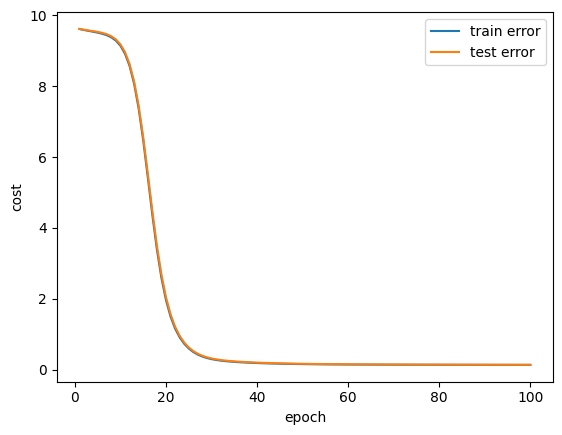

In [15]:
plt.plot(np.array(range(1, cf.n_epochs+1)), cf.train_error, label='train error')
plt.plot(np.array(range(1, cf.n_epochs+1)), cf.val_error, label='test error')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend()
print(f'Final train error is: {cf.train_error[-1]:0.2f}')
print(f'Final test error is: {cf.val_error[-1]:0.2f}')

### Finding similar cameras using collaborative filtering

Now that we have the latent features of each camera, we can find cameras that are similar to a specific camera by comparing their latent variable representation

In [16]:
query_index = random.choice(range(len(camera_list)))
query_latent_vector = cf.P[:, [query_index]]

similarities = query_latent_vector.T @ cf.P
indices = list(np.argsort(similarities.reshape((-1, )), )[::-1][:10])

In [17]:
query_code = index2camera[query_index]
print(f'query camera code:  {query_code}')
print('------- Top 10 similar cameras -------')
for i, index in enumerate(indices):
    print(f'{i+1} - ')
    print(f'camera code:    {index2camera[index]}')
    print(f'similarity:      {similarities[0, index]:0.2f}')

query camera code:  801510
------- Top 10 similar cameras -------
1 - 
camera code:    100700853
similarity:      3.59
2 - 
camera code:    631353
similarity:      3.08
3 - 
camera code:    900225
similarity:      2.93
4 - 
camera code:    900212
similarity:      2.66
5 - 
camera code:    900269
similarity:      2.44
6 - 
camera code:    900273
similarity:      2.41
7 - 
camera code:    200101
similarity:      2.38
8 - 
camera code:    900223
similarity:      2.37
9 - 
camera code:    631634
similarity:      2.32
10 - 
camera code:    10015402
similarity:      2.28
